In [2]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/icarocamelo/inf-6333-applied-ai/main/dataset/node1.csv', header=None, parse_dates=True)
data.columns = ['Timestamp', 'Formatted Timestamp', 'Busy System', 'Busy User', 'Busy Iowait', 'Busy IRQs', 'Busy Other', 'Idle']
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 672
Number of attributes = 8


,Timestamp,Formatted Timestamp,Busy System,Busy User,Busy Iowait,Busy IRQs,Busy Other,Idle
0,1646410320,2022-03-04 16:12,22.7,354.0,1.28,10.0,1.2200,477.0
1,1646410560,2022-03-04 16:16,31.1,919.0,1.12,13.7,0.1040,250.0
2,1646410800,2022-03-04 16:20,34.7,592.0,2.14,15.8,0.0851,750.0
3,1646411040,2022-03-04 16:24,33.1,830.0,1.69,25.0,0.1000,428.0
4,1646411280,2022-03-04 16:28,43.4,70.3,3.16,17.6,0.1110,1460.0


In [3]:
data.index = pd.to_datetime(data['Formatted Timestamp'])

In [4]:
import numpy as np

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [5]:
from sklearn.model_selection import train_test_split

# Consider 'Busy System' and 'Timestamp'
X, y = df_to_X_y(data['Busy System'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None)

X_train.shape, y_train.shape

((533, 5, 1), (533,))

In [6]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.layers import LSTM

model = Sequential()
model.add(InputLayer((5,1)))
# Number of cells
model.add(LSTM(64))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
17/17 [==============================] - 0s 4ms/step - loss: 7.5626
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 7.5779
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 7.5678
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 7.5192
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 7.4798
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 7.4702
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 7.3983
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 7.3841
Epoch 9/20
17/17 [==============================] - 0s 3ms/step - loss: 7.3328
Epoch 10/20
17/17 [==============================] - 0s 3ms/step - loss: 7.1352
Epoch 11/20
17/17 [==============================] - 0s 3ms/step - loss: 7.0150
Epoch 12/20
17/17 [==============================] - 0s 4ms/step - loss: 6.8568
Epoch 13/20
17/17 [==============================

In [11]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

,Train Predictions,Actuals
0,41.486305,41.2
1,41.115913,41.6
2,41.136211,40.8
3,40.939610,41.0
4,40.975819,41.9
...,...,...
528,41.027630,42.8
529,41.473759,41.8
530,41.244453,41.4
531,41.110218,41.2


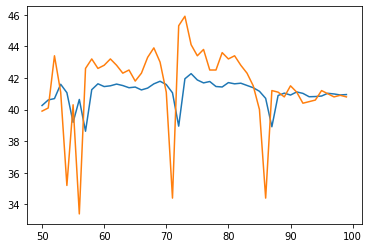

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [13]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

,Test Predictions,Actuals
0,41.071411,40.9
1,40.960430,39.3
2,40.478828,38.5
3,40.189262,36.8
4,39.632961,41.9
...,...,...
129,42.175629,45.2
130,42.122559,44.5
131,41.965534,45.3
132,42.126133,47.9


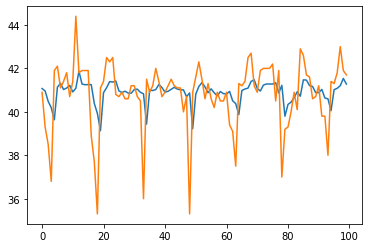

In [14]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [18]:
from sklearn.metrics import mean_absolute_percentage_error as mape

model_mape = mape(test_predictions, y_test)
model_mape

0.034433321939621245